# Different definitions of momentum
By Evgenia "Jenny" Nitishinskaya

Notebook released under the Creative Commons Attribution 4.0 License.

---

A momentum strategy is one that buys stocks whose prices seem to be rising and sells those whose prices seem to be falling. That is, it assumes that if a stock price has a lot of momentum in some direction, it will keep moving in that direction. In this notebook I try out the different definitions of momentum described in http://arxiv.org/pdf/1208.2775.pdf. They define 4 different measures, called $p^{(1)}$, $p^{(0)}$, $p^{(2)}$, and $p^{(3)}$.

Their approach is based in physics, where the momentum is defined as $p = mv$, the product of the mass and the velocity. First, they define $x(t)$ to be the log of the price of the security. Conveniently, the return on the security is then the derivative of $x(t)$, which is called the velocity $v(t)$. Then they suggest a number of different definitions of mass $m(t)$; in the examples below, we'll use the inverse of standard deviation and turnover rate as mass. This works with our analogy because the more volatile or the less liquid an asset (the smaller its mass), the easier it is to move its price (i.e. change its position). The different momenta are then defined (for a lookback window $k$) as:
$$p^{(0)}(t) = \sum_{i=0}^{k-1} v(t-i)$$
$$p^{(1)}(t) = \sum_{i=0}^{k-1} m(t-i) v(t-i)$$
$$p^{(2)}(t) = \frac{\sum_{i=0}^{k-1} m(t-i) v(t-i)}{\sum_{i=0}^{k-1} m(t-i)}$$
$$p^{(3)}(t) = \frac{\mu(v(t-k+1),\ldots, v(t))}{\sigma(v(t-k+1),\ldots, v(t))} $$

First, let's just implement the different momentum definitions, and plot the rolling momenta for one stock:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 30
start = '2014-01-01'
end = '2015-01-01'
pricing = get_pricing('PEP', fields='price', start_date=start, end_date=end)
fundamentals = init_fundamentals()
num_shares = get_fundamentals(query(fundamentals.earnings_report.basic_average_shares,)
                              .filter(fundamentals.company_reference.primary_symbol == 'PEP',), end)
x = np.log(pricing)
v = x.diff()
m = get_pricing('PEP', fields='volume', start_date=start, end_date=end)/num_shares.values[0,0]

p0 = pd.rolling_sum(v, k)
p1 = pd.rolling_sum(m*v, k)
p2 = p1/pd.rolling_sum(m, k)
p3 = pd.rolling_mean(v, k)/pd.rolling_std(v, k)

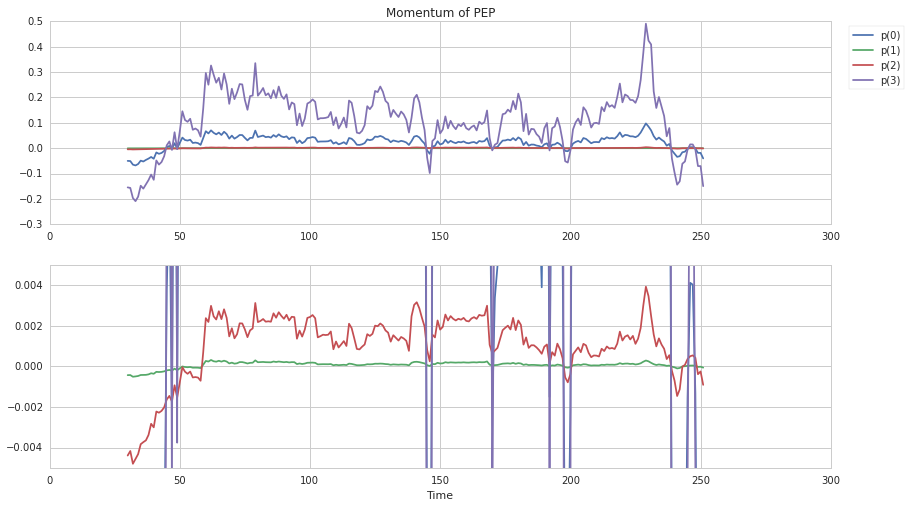

In [17]:
f, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(p0)
ax1.plot(p1)
ax1.plot(p2)
ax1.plot(p3)
ax1.set_title('Momentum of PEP')
ax1.legend(['p(0)', 'p(1)', 'p(2)', 'p(3)'], bbox_to_anchor=(1.1, 1))

ax2.plot(p0)
ax2.plot(p1)
ax2.plot(p2)
ax2.plot(p3)
ax2.axis([0, 300, -0.005, 0.005])
ax2.set_xlabel('Time');

In order to use this in a strategy, we should wrap our momentum calculator in a function:

In [3]:
def get_p(prices, m, d, k):
    """ Returns the dth-degree rolling momentum of data using lookback window length k """
    x = np.log(prices)
    v = x.diff()
    m = np.array(m)
    
    if d == 0:
        return pd.rolling_sum(v, k)
    elif d == 1:
        return pd.rolling_sum(m*v, k)
    elif d == 2:
        return pd.rolling_sum(m*v, k)/pd.rolling_sum(m, k)
    elif d == 3:
        return pd.rolling_mean(v, k)/pd.rolling_std(v, k)

Now we implement the strategy described in the paper: pick a holding period, and every period rebalance your portfolio to be long \$1000 each in the highest-momentum stocks and short \$1000 each in the lowest-momentum stocks. In the code below, my holding period is simply twice the lookback period.

/usr/local/lib/python2.7/dist-packages/pandas/tools/plotting.py:856: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


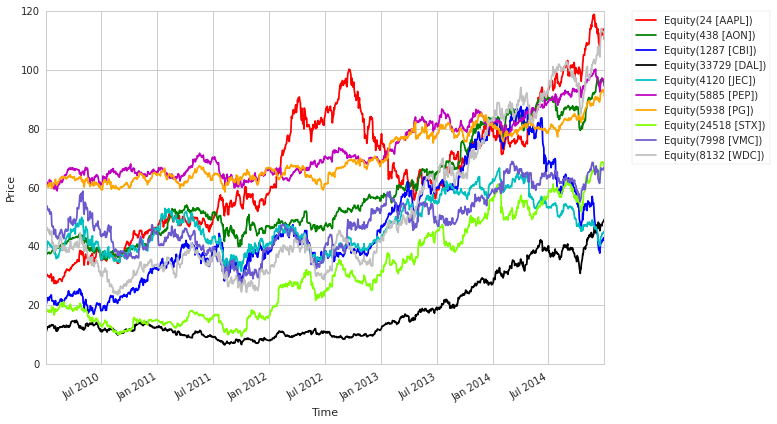

In [4]:
# Load the assets we want to trade
start = '2010-01-01'
end = '2015-01-01'
assets = sorted(['STX', 'WDC', 'CBI', 'JEC', 'VMC', 'PG', 'AAPL', 'PEP', 'AON', 'DAL'])
data = get_pricing(assets, start_date='2010-01-01', end_date='2015-01-01').loc['price', :, :]

# Get turnover rate for the assets
fundamentals = init_fundamentals()
num_shares = get_fundamentals(query(fundamentals.earnings_report.basic_average_shares,)
                              .filter(fundamentals.company_reference.primary_symbol.in_(assets),), end)
turnover = get_pricing(assets, fields='volume', start_date=start, end_date=end)/num_shares.values[0]

# Plot the prices just for fun
data.plot(figsize=(10,7), colors=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                  'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Price')
plt.xlabel('Time');

In [5]:
# Calculate all the rolling momenta for the data and compute daily ranking of assets by momentum
lookback = 30
ps = np.array([np.array(get_p(data, turnover, j, lookback).T) for j in range(4)])
orders = [[ps[j].T[i].argsort() for i in range(len(ps[0,0]))] for j in range(4)]
ranks = [[orders[j][i].argsort() for i in range(len(orders[1]))] for j in range(4)]

In [6]:
# Cast data to numpy array for easier manipulation
data_array = np.array(data)

# Simulate going long on high-momentum stocks and short low-momentum stocks
# Our first 2*lookback - 2 values will be NaN since we used 2 lookback windows, so start on day 2*lookback
tots = [[0]*4 for j in range(len(data) - 2*lookback)]
for t in range(2*lookback, len(ranks[0]) - 2*lookback):
    tots[t] = list(tots[t-1])
    # Only update portfolio every 2*lookback days
    if t%(2*lookback):
        continue
    # Go long top quintile of stocks and short bottom quintile
    shorts = np.array([[int(x < 2)for x in ranks[j][t]] for j in range(4)])
    longs = np.array([[int(x > 7) for x in ranks[j][t]] for j in range(4)])
    # How many shares of each stock are in $1000
    shares_in_1k = 1000/data_array[t]
    # Go long and short $1000 each in the specified stocks, then clear holdings in 2*lookback days
    returns = (data_array[t+2*lookback]*shares_in_1k - [1000]*len(assets))*(longs - shorts)
    tots[t] += np.sum(returns, 1)

# Adjust so that tots[t] is actually money on day t
tots = [[0,0,0,0]]*2*lookback + tots

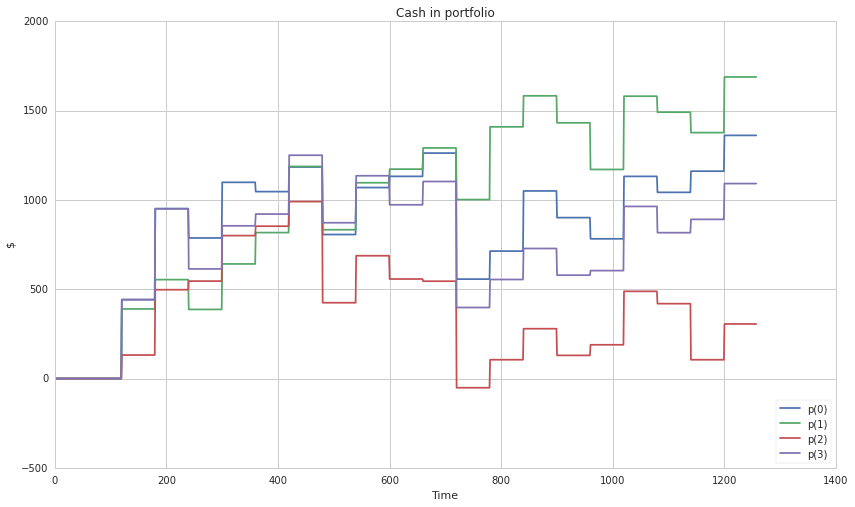

In [7]:
# Plot total money earned using the 3 different momentum definitions
plt.plot(tots)
plt.title('Cash in portfolio')
plt.legend(['p(0)', 'p(1)', 'p(2)', 'p(3)'], loc=4)
plt.xlabel('Time')
plt.ylabel('$');

## Going forward

* Implement in Zipline; it will definitely be more accurate for evaluating strategy performance.
* Pick from the whole universe of stocks.
* Reinvest cash into portfolio.
* What are good lookback and holding period lengths? I picked 30 days as a reasonable default but others might make more sense (or even different lengths for the different momentum definitions). Be careful not to overfit here!
* Try different definitions of mass. The paper suggests turnover rate and daily transaction value (and volatility is only used for $p^{(3)}$).